# Data Exploration

In [1]:
# Standard libraries
import importlib
import os
import json
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# NLP / Transformers
from transformers import AutoTokenizer
from sentence_transformers import InputExample

# Utility
from pprint import pprint

# Own Modules
import data_exploration
importlib.reload(data_exploration)

<module 'data_exploration' from 'c:\\Users\\laraw\\GitHub\\AI-Lab\\data_exploration.py'>

In [2]:
# Path to the CSV file
csv_path = "data/semeval-2022_task8_train-data_batch.csv"

# Load the data
df = pd.read_csv(csv_path)

# Show structure
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Display first few rows
df.head()

Shape: (2939, 14)
Columns: ['url1_lang', 'url2_lang', 'pair_id', 'link1', 'link2', 'ia_link1', 'ia_link2', 'Geography', 'Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone']


,url1_lang,url2_lang,pair_id,link1,link2,ia_link1,ia_link2,Geography,Entities,Time,Narrative,Overall,Style,Tone
0,en,en,1484084337_1484110209,https://www.washingtonpost.com/local/virginia-...,https://www.washingtonpost.com/world/the_ameri...,https://web.archive.org/web/www.washingtonpost...,https://web.archive.org/web/www.washingtonpost...,4.0,4.000000,1.000000,4.000000,4.000000,1.666667,2.000000
1,en,en,1484396422_1483924666,https://www.stlucianewsonline.com/guyana-three...,https://www.thestar.com/news/world/europe/2020...,https://web.archive.org/web/www.stlucianewsonl...,https://web.archive.org/web/www.thestar.com/ne...,4.0,4.000000,1.000000,4.000000,3.666667,1.666667,1.333333
2,en,en,1484698254_1483758694,https://www.teaparty.org/trump-brings-in-2020-...,https://www.timesofisrael.com/trump-says-he-do...,https://web.archive.org/web/www.teaparty.org/t...,https://web.archive.org/web/www.timesofisrael....,1.0,2.000000,1.000000,2.333333,2.333333,1.000000,1.333333
3,en,en,1576314516_1576455088,https://gadgets.ndtv.com/apps/news/zomato-uber...,https://gadgets.ndtv.com/internet/news/indian-...,https://web.archive.org/web/gadgets.ndtv.com/a...,https://web.archive.org/web/gadgets.ndtv.com/i...,1.0,2.333333,2.666667,1.666667,2.000000,1.666667,1.666667
4,en,en,1484036253_1483894099,https://news.yahoo.com/india-approves-third-mo...,https://www.channelnewsasia.com/news/asia/indi...,https://web.archive.org/web/news.yahoo.com/ind...,https://web.archive.org/web/www.channelnewsasi...,1.0,1.250000,1.000000,1.250000,1.250000,1.000000,1.000000


Overall is the label we want to learn

Continuous label -> Not Classification but Regression

similarity_bin
very different (0-1)         445
somewhat different (1-2)     544
somewhat similar(2-3)        561
very similar (3-4)          1389
Name: count, dtype: int64


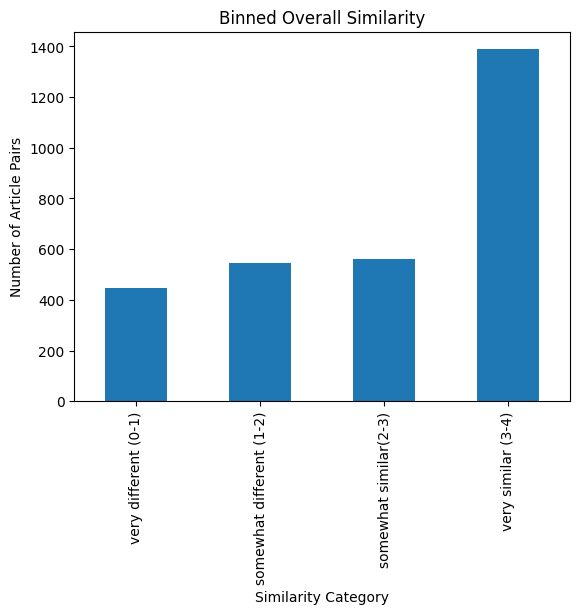

In [3]:
# Define bins and labels
bins = [0, 1, 2, 3, 4]
labels = ["very different (0-1)", "somewhat different (1-2)", "somewhat similar(2-3)", "very similar (3-4)"]
df["similarity_bin"] = pd.cut(df["Overall"], bins=bins, labels=labels, include_lowest=True)

# Show distribution
print(df["similarity_bin"].value_counts().sort_index())

# Bar plot distribution
import matplotlib.pyplot as plt

df["similarity_bin"].value_counts().sort_index().plot(kind="bar")
plt.title("Binned Overall Similarity")
plt.ylabel("Number of Article Pairs")
plt.xlabel("Similarity Category")
plt.show()

In [4]:
# Explore one pair of articles to understand csv and json structure

# Get the first row
example_row = df.iloc[0]
pair_id = str(example_row["pair_id"])

# Extract article IDs
article_ids = pair_id.split("_")
id1, id2 = article_ids[0], article_ids[1]

# Load both articles
article1 = data_exploration.load_article_json(id1)
article2 = data_exploration.load_article_json(id2)

# Combine all relevant info
example_pair = {
    "pair_id": pair_id,
    "csv_labels": example_row.to_dict(),
    "article_1": {
        "id": id1,
        "title": article1.get("title", "") if article1 else "",
        "url": article1.get("url", "") if article1 else "",
        "text_snippet": article1.get("text", "")[:500] if article1 else ""
    },
    "article_2": {
        "id": id2,
        "title": article2.get("title", "") if article2 else "",
        "url": article2.get("url", "") if article2 else "",
        "text_snippet": article2.get("text", "")[:500] if article2 else ""
    }
}

from pprint import pprint
pprint(example_pair)

{'article_1': {'id': '1484084337',
               'text_snippet': 'MARTINSBURG, W.Va. — A suspected drunken '
                               'driver was arrested in a New Year’s Day '
                               'highway crash that killed another motorist in '
                               'West Virginia, police said.\n'
                               '\n'
                               'The accident occurred early Wednesday along '
                               'southbound Interstate 81 in Berkeley County, '
                               'The Journal reported.\n'
                               '\n'
                               'Cody Wade Braithwaite, 32, of Winchester, '
                               'Virginia, was charged with DUI with death, '
                               'fleeing DUI, and being a prohibited person in '
                               'possession of a firearm and a fugitive from '
                               'justice, Berkeley County Sheriff Curtis Kell

In [5]:
# Process csv and json for all data (limited to first x for performance)

dataset_df = data_exploration.build_text_pair_dataset(df, base_path="data", limit=500)  # optional limit
display(dataset_df.head())

,pair_id,title1,text1,title2,text2,label
0,1484084337_1484110209,Virginia man arrested in fatal DUI crash in We...,"MARTINSBURG, W.Va. — A suspected drunken drive...",Haiti’s leader marks independence day amid sec...,"PORT-AU-PRINCE, Haiti — Haitian President Jove...",4.000000
1,1484396422_1483924666,Guyana: Three injured after car crashes into u...,Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...,Fire kills more than 30 animals at zoo in west...,BERLIN - A fire at a zoo in western Germany in...,3.666667
2,1484698254_1483758694,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,(Breitbart) – President Donald Trump welcomed ...,"Trump says he does not expect war with Iran, ‘...","PALM BEACH, United States — US President Donal...",2.333333
3,1576314516_1576455088,Zomato Buys Uber's Food Delivery Business in I...,Uber has sold its online food-ordering busines...,Indian Online Food Delivery Market to Hit $8 B...,Rapid digitisation and growth in both online b...,2.000000
4,1484036253_1483894099,"India approves third moon mission, months afte...",BENGALURU (Reuters) - India has approved its t...,India targets new moon mission in 2020,BANGALORE: India plans to make a fresh attempt...,1.250000
